In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

sys.path.insert(0, '/home/aew492/research-summer2020/code')
from suave import cf_model

In [2]:
# Y = A X
# where Y = data vector (dependent), A = features (including IVs), X = best-fit parameters (m & b / or B^2, a1, a2, a3)
# keep in mind, we do this fit for each mock

In [3]:
# define r vector
rmin = 20.0
rmax = 140.0
nbins = 22
r_edges = np.linspace(rmin, rmax, nbins+1)
r_avg = 0.5*(r_edges[1:]+r_edges[:-1])
len(r_avg)

22

### Y vector

In [4]:
# results of L-S estimator on entire mock (i.e. no patches)
# for now, arbitrary numbers
Y = np.ones(nbins)
print(Y.shape)

(22,)


### A matrix (features)

In [5]:
# xi_mod
alpha = 1.0
xi_mod = cf_model(alpha*r_avg, cosmo_base=None, redshift=0.57, bias=2.0)

In [6]:
A = np.array([xi_mod, 1/r_avg**2, 1/r_avg, np.ones(nbins)]).T
print(A.shape)

(22, 4)


### C matrix (covariance)

In [7]:
# ones for now
C = np.identity(len(Y))
C_inv = np.linalg.inv(C)

### least squares fit: Y = A @ X

In [8]:
X = np.linalg.inv(A.T @ C_inv @ A) @ (A.T @ C_inv @ Y)
print(X.shape, X)

(4,) [-1.45519152e-11  1.86264515e-09 -1.45519152e-11  1.00000000e+00]


In [9]:
# these are our best-fit parameters: B**2, a1, a2, a3

In [10]:
# next steps:
# - gridded fit:
#     with our best-fit parameters, we perform a chi squared fit at many intervals \Delta\alpha to determine \alpha
#     (we now have a best-fit correlation function analogous to the result of bao_iterative for suave)
# - application to gradient:
#     L-S in each patch, then a simultaneous fit between each bin in each patch—
#        but using our new \xi_fit instead of the fiducial cosmology to be more fair to the standard approach

# real data!

### load in data

In [11]:
data_fn = '/scratch/aew492/research-summer2020_output/gradient/1D'
cat_tag = 'L750_n1e-4_z057_patchy_As2x'
rlz = 0
m = 1
b = 0.5

In [12]:
# results of L-S estimator on entire mock (i.e. no patches)
xi_ls = np.load(os.path.join(data_fn, f'ls/{cat_tag}/xi_ls_3x_cat_{cat_tag}_lognormal_rlz{rlz}_m-{m}.000-L_b-{b}00.npy'), allow_pickle=True)
print(xi_ls.shape)

(2, 22)


In [13]:
r_avg = xi_ls[0]

### Landy-Szalay results (Y vector)

In [14]:
Y = xi_ls[1]
print(Y.shape)

(22,)


### feature (A) matrix

In [15]:
# xi_mod
alpha = 1.0
xi_mod = cf_model(alpha*r_avg, cosmo_base=None, redshift=0.57, bias=2.0)

In [16]:
A = np.array([xi_mod, 1/r_avg**2, 1/r_avg, np.ones(nbins)]).T
print(A.shape)

(22, 4)


### covariance (C) matrix

In [17]:
# ones for now
C = np.identity(len(Y))
C_inv = np.linalg.inv(C)

### performing the fit: finding best-fit parameters for given alpha

In [18]:
X = np.linalg.inv(A.T @ C_inv @ A) @ (A.T @ C_inv @ Y)
B_sq, a1, a2, a3 = X
print(X.shape, X)

(4,) [ 1.55802589e+00 -5.60190730e+01  5.40573662e-01 -1.30789137e-03]


In [19]:
# putting X values back into equation for xi_fit— but we'll use a finer r grid for a smoother plot
ncont = 1000
r_avg_fine = np.linspace(rmin, rmax, ncont+1)
xi_mod_fine = cf_model(alpha*r_avg_fine, cosmo_base=None, redshift=0.57, bias=2.0)

xi_fit = B_sq*xi_mod_fine + a1/r_avg_fine**2 + a2/r_avg_fine + a3
xi_fit.shape

(1001,)

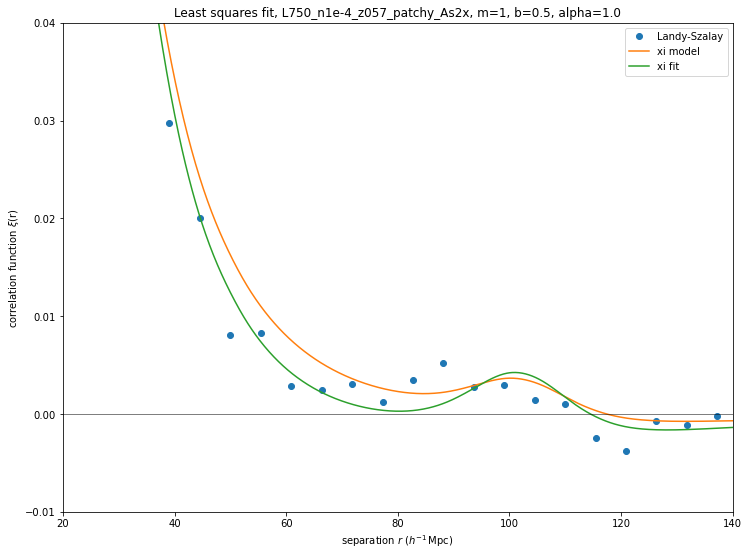

In [20]:
# visualization
fig, ax = plt.subplots(figsize=(12,9))

plt.plot(r_avg, Y, marker='o', linestyle='None', label='Landy-Szalay')
plt.plot(r_avg_fine, xi_mod_fine, label='xi model')
plt.plot(r_avg_fine, xi_fit, label='xi fit')

ax.set_xlim(20, 140)
ax.set_ylim(-.01, 0.04)
plt.axhline(0, color="k", alpha=0.5, lw=1)
ax.set_xlabel(r'separation $r$ ($h^{-1}\,$Mpc)')
ax.set_ylabel(r'correlation function $\xi$(r)')
ax.set_title(f'Least squares fit, {cat_tag}, m={m}, b={b}, alpha={alpha}')
plt.legend()

## functions + multiple alpha values

In [21]:
# we do this for a bunch of different alpha values:
def lst_sq_fit(alpha, xi_ls, cov=None):
    r_avg = xi_ls[0]
    nbins = len(r_avg)
    Y = xi_ls[1]
    xi_mod = cf_model(alpha*r_avg, cosmo_base=None, redshift=0.57, bias=2.0)
    A = np.array([xi_mod, 1/r_avg**2, 1/r_avg, np.ones(nbins)]).T
    
    if cov==None:
        C = np.identity(len(Y))
        C_inv = np.linalg.inv(C)
    else:
        assert False, "covs must be 1 for now"
    
    X = np.linalg.inv(A.T @ C_inv @ A) @ (A.T @ C_inv @ Y)
    B_sq, a1, a2, a3 = X
    
    xi_fit = B_sq*xi_mod + a1/r_avg**2 + a2/r_avg + a3
    
    return xi_fit

In [22]:
xi_fit = lst_sq_fit(1.0, xi_ls)

In [23]:
alpha_grid = np.linspace(0.75, 1.25, 51)
nalphas = len(alpha_grid)

In [24]:
alpha_grid

array([0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85,
       0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96,
       0.97, 0.98, 0.99, 1.  , 1.01, 1.02, 1.03, 1.04, 1.05, 1.06, 1.07,
       1.08, 1.09, 1.1 , 1.11, 1.12, 1.13, 1.14, 1.15, 1.16, 1.17, 1.18,
       1.19, 1.2 , 1.21, 1.22, 1.23, 1.24, 1.25])

In [25]:
data_fn = '/scratch/aew492/research-summer2020_output/gradient/1D'
cat_tag = 'L750_n1e-4_z057_patchy_As2x'
rlz = 0
m = 1
b = 0.5
xi_ls = np.load(os.path.join(data_fn, f'ls/{cat_tag}/xi_ls_3x_cat_{cat_tag}_lognormal_rlz{rlz}_m-{m}.000-L_b-{b}00.npy'), allow_pickle=True)
nbins = len(xi_ls[0])

In [26]:
xi_fits = np.empty((nalphas, nbins))
for i in range(nalphas):
    xi_fit = lst_sq_fit(alpha_grid[i], xi_ls)
    xi_fits[i] = xi_fit

In [27]:
xi_fits.shape, len(xi_fits[0])

((51, 22), 22)

In [28]:
# chi-squared test: find the alpha which minimizes chi-squared
chi_squared = np.sum((xi_ls[1] - xi_fits[0])**2 / xi_fits[0])

In [29]:
chi_squared

-4.978696155846698

In [30]:
chi_squareds = np.ones(nalphas)
for i in range(nalphas):
    diff = xi_ls[1] - xi_fits[i]
    chi_squared = np.dot(diff, np.linalg.solve(C, diff)) #***
    chi_squareds[i] = chi_squared

In [31]:
chi_squareds

array([1.80404978e-04, 1.80516860e-04, 1.80578506e-04, 1.80602915e-04,
       1.80605068e-04, 1.80600761e-04, 1.80601567e-04, 1.80605858e-04,
       1.80588614e-04, 1.80490690e-04, 1.80219224e-04, 1.79653547e-04,
       1.78643464e-04, 1.77015918e-04, 1.74607297e-04, 1.71283890e-04,
       1.66957492e-04, 1.61609615e-04, 1.55329373e-04, 1.48284824e-04,
       1.40648452e-04, 1.32629087e-04, 1.24509681e-04, 1.16619444e-04,
       1.09204044e-04, 1.02433207e-04, 9.64106045e-05, 9.12264893e-05,
       8.70043572e-05, 8.38293487e-05, 8.17142644e-05, 8.05934073e-05,
       8.03346285e-05, 8.08167049e-05, 8.20072994e-05, 8.38891564e-05,
       8.64221606e-05, 8.95361087e-05, 9.31338839e-05, 9.71254237e-05,
       1.01480218e-04, 1.06170107e-04, 1.11141551e-04, 1.16319722e-04,
       1.21613798e-04, 1.26926067e-04, 1.32179886e-04, 1.37327599e-04,
       1.42326456e-04, 1.47121313e-04, 1.51649701e-04])

Text(0.5, 1.0, 'Chi-squared, L750_n1e-4_z057_patchy_As2x, m=1, b=0.5, range of alphas')

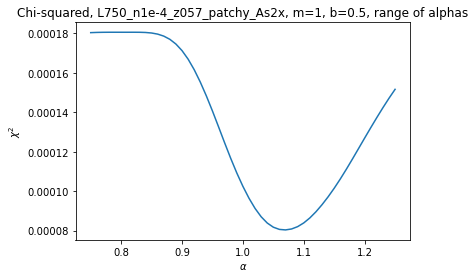

In [32]:
fig, ax = plt.subplots()

plt.plot(alpha_grid, chi_squareds)

ax.set_xlabel(r'$\alpha$')
ax.set_ylabel(r'$\chi^2$')
ax.set_title(f'Chi-squared, {cat_tag}, m={m}, b={b}, range of alphas')